In [1]:
# Import Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix,
                             roc_auc_score,
                             average_precision_score)
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, cohen_kappa_score, brier_score_loss
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Bidirectional, Dropout
from keras.regularizers import l1_l2
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.utils import resample
# import shap


import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

# import umap

import xgboost as xgb

import warnings
import time
warnings.filterwarnings("ignore")

from multiprocessing import Pool
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from collections import Counter

import gc
from joblib import Parallel, delayed
# from pyod.models.knn import KNN
# from pyod.models.iforest import IForest
# from pyod.models.abod import ABOD

In [9]:
# LSTM model setup
model_temp = Sequential()
model_temp.add(LSTM(50, input_shape=(12,41), return_sequences=True))
model_temp.add(LSTM(50))
model_temp.add(Dense(1, activation='sigmoid'))

# Compile the model
model_temp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model_temp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 50)            18400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38651 (150.98 KB)
Trainable params: 38651 (150.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


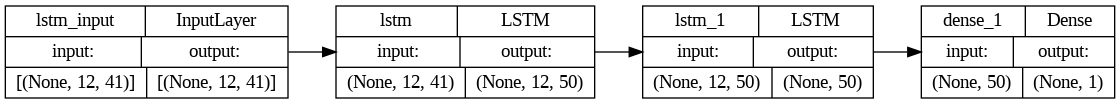

In [10]:
plot_model(model_temp, show_shapes=True, show_layer_names=True, rankdir='LR')

# Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# set up table for all loans
df = pd.read_csv('/content/drive/My Drive/MBS Study/df_final.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Loan Sequence Number,Monthly Reporting Period,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Delinquency Due to Disaster,Interest Bearing UPB,Original UPB,...,Occupancy Status_S,Property Type_CO,Property Type_CP,Property Type_MH,Property Type_PU,Property Type_SF,Property Valuation Method_1.0,Property Valuation Method_2.0,Property Valuation Method_3.0,Property Valuation Method_9.0
0,F11Q10000044,2011-02-01,135000.00,0,0.0,360.0,4.625,0,135000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
1,F11Q10000044,2011-03-01,135000.00,0,1.0,359.0,4.625,0,135000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
2,F11Q10000044,2011-04-01,135000.00,0,2.0,358.0,4.625,0,135000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
3,F11Q10000044,2011-05-01,134000.00,0,3.0,357.0,4.625,0,134000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
4,F11Q10000044,2011-06-01,134000.00,0,4.0,356.0,4.625,0,134000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014603,F19Q40515256,2022-11-01,115037.14,16,34.0,326.0,4.125,0,115037.14,118000.0,...,False,False,False,False,False,True,False,True,False,False
2014604,F19Q40515256,2022-12-01,115037.14,17,35.0,325.0,4.125,0,115037.14,118000.0,...,False,False,False,False,False,True,False,True,False,False
2014605,F19Q40515256,2023-01-01,115037.14,18,36.0,324.0,4.125,0,115037.14,118000.0,...,False,False,False,False,False,True,False,True,False,False
2014606,F19Q40515256,2023-02-01,115037.14,19,37.0,323.0,4.125,0,115037.14,118000.0,...,False,False,False,False,False,True,False,True,False,False


## Create shifted label

In [3]:
# Convert 'Monthly Reporting Period' to datetime type for proper sorting and manipulation
df['Monthly Reporting Period'] = pd.to_datetime(df['Monthly Reporting Period'])

# Sort the DataFrame by 'Loan Sequence Number' and 'Monthly Reporting Period' to ensure correct label alignment
df.sort_values(by=['Loan Sequence Number', 'Monthly Reporting Period'], inplace=True)

# Group by 'Loan Sequence Number' and shift 'Label' up by one to create the 'label_target'
df['label_target'] = df.groupby('Loan Sequence Number')['Label'].shift(-1)

# Drop rows where 'label_target' is NaN, indicating no subsequent month data for the same loan sequence number
df = df.dropna(subset=['label_target'])
df = df.drop(columns = {'Label'})
df = df.reset_index(drop = True)

In [4]:
df['target_0&1'] = df['label_target'].apply(lambda x: 0 if x in [0, 1] else 1)

## Create Test Dataset

In [5]:
df = df.sort_values('Loan Sequence Number')

# Get a list of unique loan sequence numbers
unique_loans = df['Loan Sequence Number'].unique()

# Calculate the count for 10% of these unique loan sequence numbers
ten_percent_count = int(len(unique_loans) * 0.1)

# Randomly sample 10% of the unique loan sequence numbers
# Setting a random state for reproducibility in this example
ten_percent_loans = np.random.choice(unique_loans, size=ten_percent_count, replace=False)

# Split the DataFrame based on the sampled loan sequence numbers
df_test = df[df['Loan Sequence Number'].isin(ten_percent_loans)]
df = df[~df['Loan Sequence Number'].isin(ten_percent_loans)]
df = df.sort_values(['Loan Sequence Number', 'Monthly Reporting Period']).reset_index(drop = True)
df_test = df_test.sort_values(['Loan Sequence Number', 'Monthly Reporting Period']).reset_index(drop = True)
# (df_test.head(), df.head())

# Create Windowed Dataset

In [6]:
# Define columns of different types
columns_orig = [
       'Original UPB', 'Mortgage Insurance Percentage (MI %)',
       'Original Loan-to-Value (LTV)', 'Original Interest Rate', 'Super Conforming Flag', 'Credit Score',
       'Original Debt-to-Income (DTI) Ratio',
       'Number of Borrowers', 'Number of Units', 'Property Valuation Method',
       'Valid DTI Ratio', 'Channel_B', 'Channel_C', 'Channel_R', 'Loan Purpose_C',
       'Loan Purpose_N', 'Loan Purpose_P', 'First Time Homebuyer Flag_N',
       'First Time Homebuyer Flag_Y', 'Occupancy Status_I',
       'Occupancy Status_P', 'Occupancy Status_S', 'Property Type_CO',
       'Property Type_CP', 'Property Type_MH', 'Property Type_PU',
       'Property Type_SF']

columns_monthly = [
       'Monthly Reporting Period',
       'Current Actual UPB', 'Current Loan Delinquency Status', 'Loan Age',
       'Remaining Months to Legal Maturity',
       'Current Interest Rate', 'Delinquency Due to Disaster', 'Interest Bearing UPB',
       'Label']

columns_categorical_final = [
       'Valid DTI Ratio',
       'Super Conforming Flag',
       'Delinquency Due to Disaster',
       'Channel',
       'Loan Purpose',
       'First Time Homebuyer Flag',
       'Occupancy Status',
       'Property Type',
       'Property Valuation Method']

columns_continuous = [
       'Current Actual UPB', 'Current Loan Delinquency Status', 'Loan Age',
       'Remaining Months to Legal Maturity', 'Current Interest Rate',
       'Interest Bearing UPB', 'Original UPB',
       'Mortgage Insurance Percentage (MI %)', 'Original Loan-to-Value (LTV)',
       'Original Interest Rate',
       'Credit Score',
       'Original Debt-to-Income (DTI) Ratio', 'Number of Borrowers',
       'Number of Units','Valid DTI Ratio',
       'Housing Price', 'CPI', 'Unemployment_Rate', 'Recession'
]

columns_to_process = ['Current Actual UPB', 'Current Loan Delinquency Status', 'Loan Age',
       'Remaining Months to Legal Maturity', 'Current Interest Rate',
       'Delinquency Due to Disaster', 'Interest Bearing UPB', 'Original UPB',
       'Mortgage Insurance Percentage (MI %)', 'Original Loan-to-Value (LTV)',
       'Original Interest Rate', 'Super Conforming Flag', 'Credit Score',
       'Original Debt-to-Income (DTI) Ratio', 'Number of Borrowers',
       'Number of Units', 'Valid DTI Ratio', 'Housing Price', 'CPI',
       'Unemployment_Rate', 'Recession', 'Channel_B', 'Channel_C', 'Channel_R',
       'Loan Purpose_C', 'Loan Purpose_N', 'Loan Purpose_P',
       'First Time Homebuyer Flag_N', 'First Time Homebuyer Flag_Y',
       'Occupancy Status_I', 'Occupancy Status_P', 'Occupancy Status_S',
       'Property Type_CO', 'Property Type_CP', 'Property Type_MH',
       'Property Type_PU', 'Property Type_SF', 'Property Valuation Method_1.0',
       'Property Valuation Method_2.0', 'Property Valuation Method_3.0',
       'Property Valuation Method_9.0']

In [7]:
# def create_windowed_data_with_padding_optimized(dataframe, date_col, window_size=12):
#     df_values = dataframe.drop(columns=[date_col]).values
#     df_index = dataframe.index.to_numpy()

#     unique_sequences = np.unique(df_index)
#     sequence_data = {}

#     for sequence in tqdm(unique_sequences, desc="Processing"):
#         sequence_indices = np.where(df_index == sequence)[0]
#         sequence_data_array = df_values[sequence_indices]
#         num_entries = sequence_data_array.shape[0]

#         windows = []
#         for start_idx in range(num_entries):
#             end_idx = start_idx + window_size
#             window = sequence_data_array[max(start_idx - window_size + 1, 0):start_idx + 1]

#             # Pad the window if it's not the full size
#             if window.shape[0] < window_size:
#                 pad_size = window_size - window.shape[0]
#                 pad = np.zeros((pad_size, sequence_data_array.shape[1]))
#                 window = np.vstack((pad, window))

#             windows.append(window)

#         sequence_data[sequence] = np.array(windows)

#     return sequence_data

# # Before applying the function, make sure the dataframe is sorted properly
# df_sorted = df.sort_values(by='Monthly Reporting Period')
# df_sorted = df_sorted.drop(columns = {'label_target', 'target_0&1'})
# df_sorted = df_sorted.set_index('Loan Sequence Number')

# # Apply the function to the sorted dataframe
# windowed_data_with_padding_optimized = create_windowed_data_with_padding_optimized(df_sorted, date_col='Monthly Reporting Period')


In [8]:
def create_windowed_data_with_padding_optimized(dataframe, window_size=12):
    # Create a zero-padding array once, with the same width as the dataframe
    pad = np.zeros((window_size - 1, dataframe.shape[1]))

    sequence_data = {}

    # Group by the sequence index (assuming the dataframe is sorted by date)
    for sequence, group in tqdm(dataframe.groupby(level=0), desc="Processing"):
        # Convert group to numpy array for efficiency
        group_values = group.values

        # Pre-calculate the window indices to avoid doing this inside the loop
        window_indices = [(max(i - window_size + 1, 0), i + 1) for i in range(len(group))]

        # Create the windows using a list comprehension and the pre-calculated indices
        windows = [np.vstack((pad[:max(0, window_size - len(group_values[start:end])), :], group_values[start:end]))
                   for start, end in window_indices]

        sequence_data[sequence] = np.array(windows)

    return sequence_data

# Make sure the dataframe is sorted by the date column before setting the index
df_sorted = df.sort_values(by='Monthly Reporting Period')
df_sorted.set_index('Loan Sequence Number', inplace=True)
df_sorted.drop(columns=['Monthly Reporting Period', 'label_target', 'target_0&1'], inplace=True)

# Apply the function to the sorted dataframe
windowed_data_with_padding = create_windowed_data_with_padding_optimized(df_sorted)

Processing:   0%|          | 0/36655 [00:00<?, ?it/s]

# LSTM Model

## Create Training data and labels

In [9]:
# Initialize Training data and Labels
X = np.concatenate(list(windowed_data_with_padding.values()))
y = df['target_0&1'].values
loan_sequence_numbers = df['Loan Sequence Number']

In [10]:
print("train shape: ", X.shape)
print("label shape: ", y.shape)

train shape:  (1779174, 12, 41)
label shape:  (1779174,)


In [11]:
del df_sorted

In [12]:
# del df

In [13]:
del windowed_data_with_padding
gc.collect()

73347

In [14]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = np.array([scaler.fit_transform(window) for window in tqdm(X, desc='Scaling Windows')])

Scaling Windows:   0%|          | 0/1779174 [00:00<?, ?it/s]

In [15]:
del X
gc.collect()

18

In [16]:
# Split data into train and test sets
X_train, X_test, y_train, y_test, loans_train, loans_test = train_test_split(
    X_scaled, y, loan_sequence_numbers, test_size=0.2, random_state=42
)

In [17]:
# del X_scaled
# del y
# gc.collect()

## Model 1: LSTM Baseline

In [18]:
# # LSTM model setup
# model = Sequential()
# model.add(CuDNNLSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(CuDNNLSTM(50))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(
#     X_train,
#     y_train,
#     epochs=1,
#     batch_size=32,
#     validation_data=(X_test, y_test)  # Use the test data for validation
# )

# # Generate predictions
# y_pred = (model.predict(X_test) > 0.8).astype("int32")

# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred)

# # Plot confusion matrix
# sns.heatmap(cm, annot=True, fmt='d')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()

## Model 2: LSTM + Class Weights

In [18]:
tf.keras.backend.clear_session()

11120/11120 [==============================] - 24s 2ms/step


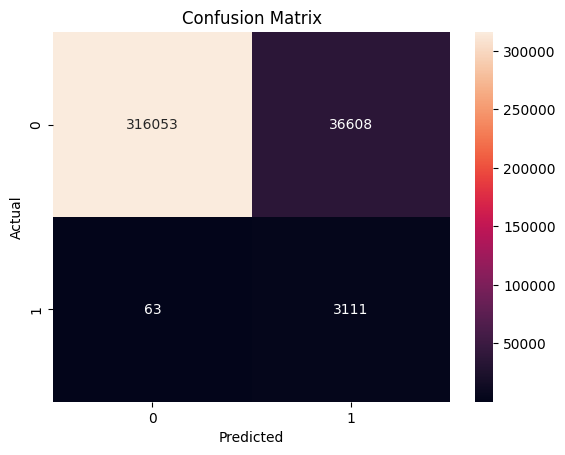

              precision    recall  f1-score   support

     Class 0       1.00      0.90      0.95    352661
     Class 1       0.08      0.98      0.15      3174

    accuracy                           0.90    355835
   macro avg       0.54      0.94      0.55    355835
weighted avg       0.99      0.90      0.94    355835



In [19]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# LSTM model setup
model2 = Sequential()
model2.add(CuDNNLSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model2.add(CuDNNLSTM(50))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# Use class weights in the model fitting
model2.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict)

# Generate predictions
y_pred2 = (model2.predict(X_test) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred2)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test, y_pred2, target_names=['Class 0', 'Class 1'])

print(report)

## Model 3: LSTM + Oversampling

In [19]:
X_train.shape

(1421578, 12, 41)

11107/11107 [==============================] - 24s 2ms/step


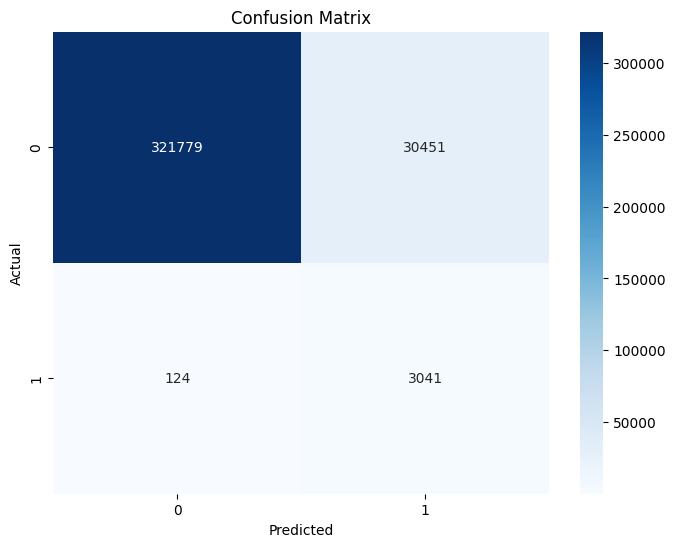

              precision    recall  f1-score   support

     Class 0       1.00      0.91      0.95    352230
     Class 1       0.09      0.96      0.17      3165

    accuracy                           0.91    355395
   macro avg       0.55      0.94      0.56    355395
weighted avg       0.99      0.91      0.95    355395



In [20]:
# Upsample the minority class
ros = RandomOverSampler(sampling_strategy='minority')
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.reshape(-1, 12 * 41), y_train)
X_train_resampled = X_train_resampled.reshape(-1, 12, 41)

# LSTM model setup
model3 = Sequential()
model3.add(CuDNNLSTM(50, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2]), return_sequences=True))
model3.add(CuDNNLSTM(50))
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the resampled training data
model3.fit(X_train_resampled, y_train_resampled, epochs=1, batch_size=32, validation_data=(X_test, y_test))

# Generate predictions on the original test set
y_pred3 = (model3.predict(X_test) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test, y_pred3, target_names=['Class 0', 'Class 1'])
print(report)

# Plots of sample loans

## Example of Default Loan

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

Scaling Windows:   0%|          | 0/17 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


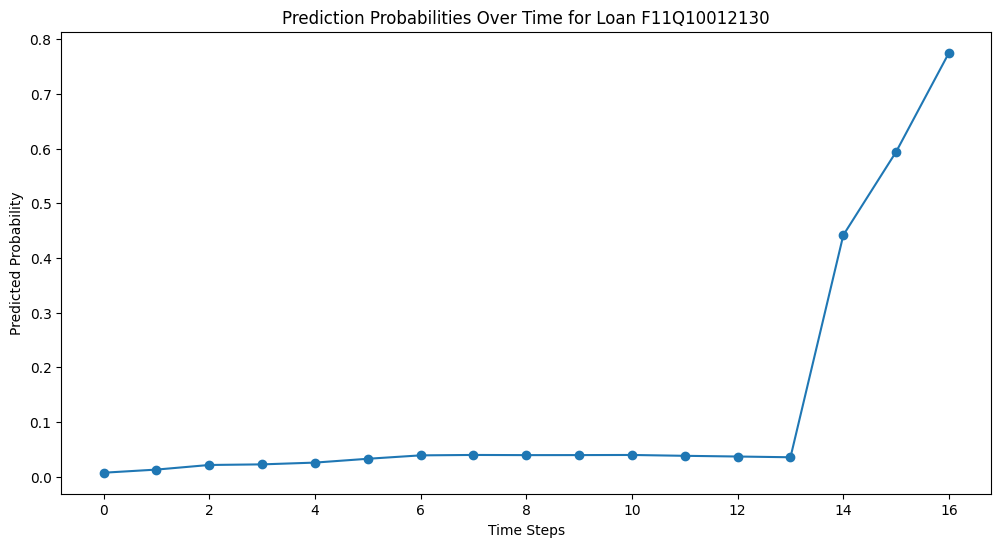

In [27]:
loan_id = 'F11Q10012130'  # example loan ID from your dataset

df_sorted_test = df_test[df_test['Loan Sequence Number'] == loan_id].sort_values(by='Monthly Reporting Period')
df_sorted_test.set_index('Loan Sequence Number', inplace=True)
df_sorted_test.drop(columns=['Monthly Reporting Period', 'label_target', 'target_0&1'], inplace=True)

# Apply the function to the sorted dataframe
df_test_window = create_windowed_data_with_padding_optimized(df_sorted_test)
df_test_window =np.concatenate(list(df_test_window.values()))

# Scale the windows
scaler = MinMaxScaler()
loan_windows = np.array([scaler.fit_transform(window) for window in tqdm(df_test_window, desc='Scaling Windows')])

# Predict the probabilities for each window
probabilities = model2.predict(loan_windows)  # Flatten in case the output has an extra dimension

# Plot these probabilities over time
plt.figure(figsize=(12, 6))
plt.plot(probabilities, marker='o')
plt.title(f'Prediction Probabilities Over Time for Loan {loan_id}')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Probability')
plt.show()

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

Scaling Windows:   0%|          | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


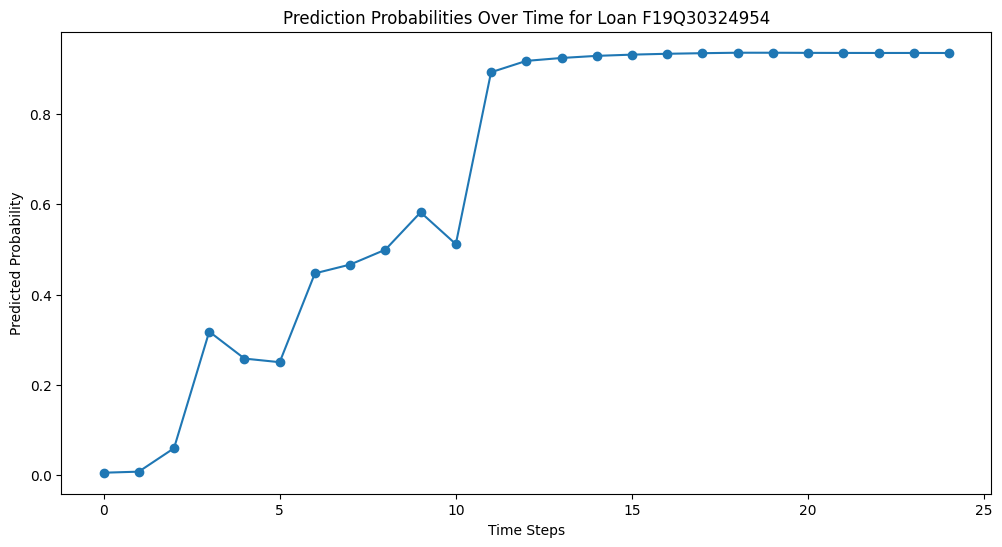

In [29]:
loan_id = 'F19Q30324954'  # example loan ID from your dataset

df_sorted_test = df_test[df_test['Loan Sequence Number'] == loan_id].sort_values(by='Monthly Reporting Period')
df_sorted_test.set_index('Loan Sequence Number', inplace=True)
df_sorted_test.drop(columns=['Monthly Reporting Period', 'label_target', 'target_0&1'], inplace=True)

# Apply the function to the sorted dataframe
df_test_window = create_windowed_data_with_padding_optimized(df_sorted_test)
df_test_window =np.concatenate(list(df_test_window.values()))

# Scale the windows
scaler = MinMaxScaler()
loan_windows = np.array([scaler.fit_transform(window) for window in tqdm(df_test_window, desc='Scaling Windows')])

# Predict the probabilities for each window
probabilities = model2.predict(loan_windows)  # Flatten in case the output has an extra dimension

# Plot these probabilities over time
plt.figure(figsize=(12, 6))
plt.plot(probabilities, marker='o')
plt.title(f'Prediction Probabilities Over Time for Loan {loan_id}')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Probability')
plt.show()

## Example of Paid off Loan

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

Scaling Windows:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


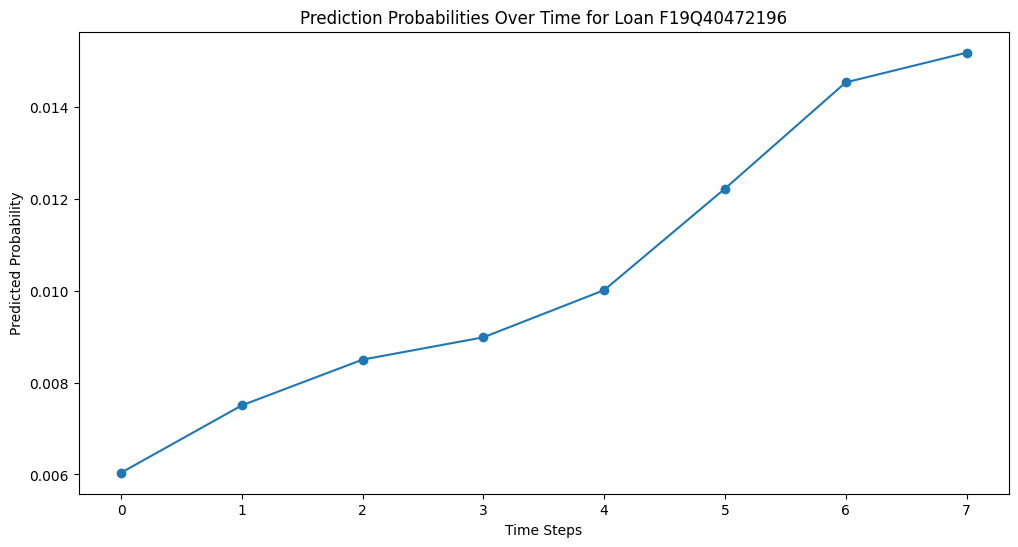

In [23]:
loan_id = 'F19Q40472196'  # example loan ID from your dataset

df_sorted_test = df_test[df_test['Loan Sequence Number'] == loan_id].sort_values(by='Monthly Reporting Period')
df_sorted_test.set_index('Loan Sequence Number', inplace=True)
df_sorted_test.drop(columns=['Monthly Reporting Period', 'label_target', 'target_0&1'], inplace=True)

# Apply the function to the sorted dataframe
df_test_window = create_windowed_data_with_padding_optimized(df_sorted_test)
df_test_window =np.concatenate(list(df_test_window.values()))

# Scale the windows
scaler = MinMaxScaler()
loan_windows = np.array([scaler.fit_transform(window) for window in tqdm(df_test_window, desc='Scaling Windows')])

# Predict the probabilities for each window
probabilities = model2.predict(loan_windows)  # Flatten in case the output has an extra dimension

# Plot these probabilities over time
plt.figure(figsize=(12, 6))
plt.plot(probabilities, marker='o')
plt.title(f'Prediction Probabilities Over Time for Loan {loan_id}')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Probability')
plt.show()

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

Scaling Windows:   0%|          | 0/125 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


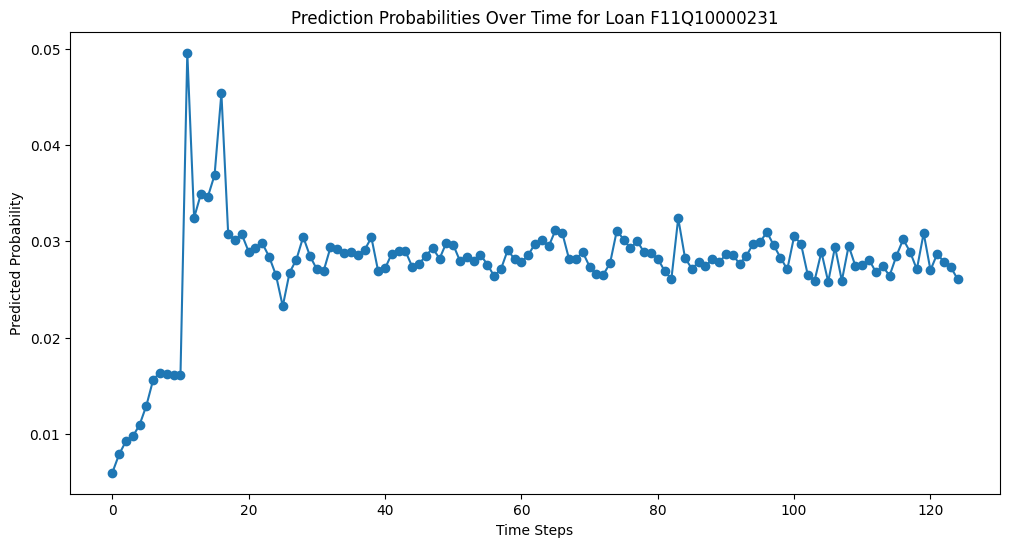

In [25]:
loan_id = 'F11Q10000231'  # example loan ID from your dataset

df_sorted_test = df_test[df_test['Loan Sequence Number'] == loan_id].sort_values(by='Monthly Reporting Period')
df_sorted_test.set_index('Loan Sequence Number', inplace=True)
df_sorted_test.drop(columns=['Monthly Reporting Period', 'label_target', 'target_0&1'], inplace=True)

# Apply the function to the sorted dataframe
df_test_window = create_windowed_data_with_padding_optimized(df_sorted_test)
df_test_window =np.concatenate(list(df_test_window.values()))

# Scale the windows
scaler = MinMaxScaler()
loan_windows = np.array([scaler.fit_transform(window) for window in tqdm(df_test_window, desc='Scaling Windows')])

# Predict the probabilities for each window
probabilities = model2.predict(loan_windows)  # Flatten in case the output has an extra dimension

# Plot these probabilities over time
plt.figure(figsize=(12, 6))
plt.plot(probabilities, marker='o')
plt.title(f'Prediction Probabilities Over Time for Loan {loan_id}')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Probability')
plt.show()

Predicting:   0%|          | 0/4072 [00:00<?, ?loan/s]

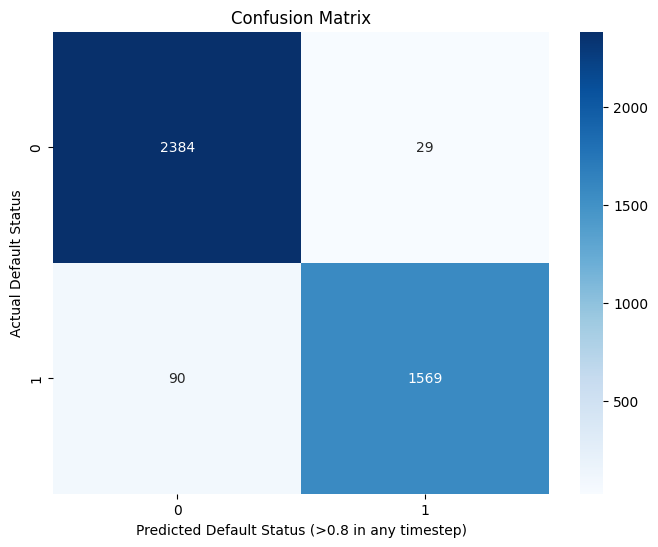

In [47]:
def create_windowed_data_temp(dataframe, window_size=12):
    pad = np.zeros((window_size - 1, dataframe.shape[1]))
    sequence_data = {}

    for sequence, group in dataframe.groupby(level=0):
        group_values = group.values
        window_indices = [(max(i - window_size + 1, 0), i + 1) for i in range(len(group))]
        windows = [np.vstack((pad[:max(0, window_size - len(group_values[start:end])), :], group_values[start:end]))
                   for start, end in window_indices]
        sequence_data[sequence] = np.array(windows)

    return sequence_data

# Pre-grouping the data
grouped_loans = df_test.groupby('Loan Sequence Number')

# Get actual defaults for the last day
last_day_defaults = grouped_loans['target_0&1'].last()

loan_max_probabilities = {}

for loan_id, loan_data in tqdm(grouped_loans, desc='Predicting', unit='loan'):
    loan_data_sorted = loan_data.sort_values(by='Monthly Reporting Period')
    loan_data_sorted.set_index('Loan Sequence Number', inplace=True)
    loan_data_sorted.drop(columns=['Monthly Reporting Period', 'label_target', 'target_0&1'], inplace=True)

    loan_windows = create_windowed_data_temp(loan_data_sorted)
    loan_windows_concat = np.concatenate(list(loan_windows.values()))

    scaler = MinMaxScaler()
    loan_test = np.array([scaler.fit_transform(window) for window in loan_windows_concat])

    # Batch prediction
    predicted_probabilities = model2.predict(loan_test, verbose=0)
    max_probability = np.max(predicted_probabilities)

    loan_max_probabilities[loan_id] = max_probability

predicted_defaults = np.array(list(loan_max_probabilities.values())) > 0.8
actual_defaults = last_day_defaults.reindex(loan_max_probabilities.keys()).values

cm = confusion_matrix(actual_defaults, predicted_defaults)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Default Status')
plt.xlabel('Predicted Default Status (>0.8 in any timestep)')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Generate classification report
report = classification_report(actual_defaults, predicted_defaults, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.98      2413
     Class 1       0.98      0.95      0.96      1659

    accuracy                           0.97      4072
   macro avg       0.97      0.97      0.97      4072
weighted avg       0.97      0.97      0.97      4072

